This code: merges CSV files, shows which days and hours are in the collective database, creates df, converts x, y, values in to date-time and price including VAT and energy tax (2025).it shows the development of price predictions for the period -4 hours till 7 x 24 hours in the future.


In [22]:
import os
import pandas as pd
import glob

# Define the folder containing the CSV files
folder_path = "oxygent_data"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv")) + glob.glob(os.path.join(folder_path, "*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.split("_")[-1].replace(":", "").replace(".csv", "").replace(".CSV", ""))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
merged_df = pd.concat(df_list, ignore_index=True)

# Save the merged data
merged_df.to_csv("merged_data.csv", index=False)

print(f"Merged {len(csv_files)} files into 'merged_data.csv'")

Merged 352 files into 'merged_data.csv'


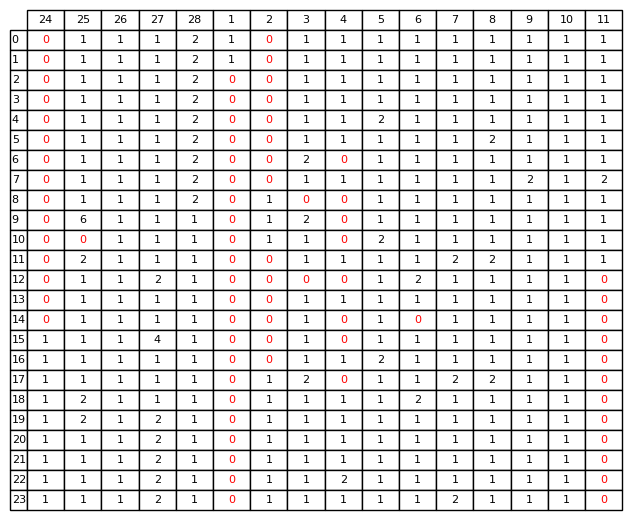

In [23]:
# Convert the 'timestamp' column to datetime in ISO 8601 format
merged_df['timestamp_iso'] = pd.to_datetime(merged_df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S.%f%z')

# Extract dates from the 'timestamp_iso' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.date
# Extract hour from the 'timestamp_iso' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.hour

# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Convert column index to datetime and extract the day
pivot_table.columns = pd.to_datetime(pivot_table.columns).day

# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')


table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)



plt.show()

In [24]:
#creating a leaner dataframe, excluding non-relevant columns
lean_df = merged_df.drop(columns=['timestamp', 'timestamp_iso'])
print(lean_df.columns)

Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp'], dtype='object')


In [25]:
from datetime import datetime

#conversion of x to datetime
def add_datetime_column(df):
    # Convert x values to milliseconds and then to datetime
    lean_df['date_time'] = lean_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))
    return df

# Assuming df is already defined in the previous cell
lean_df['Price'] = lean_df['y'].apply(lambda y: (y * 1.21) + 0.1228)  # Calculate price values

# Add the date_time column
lean_df = add_datetime_column(lean_df)

print(lean_df.columns)
print(lean_df.head(2))
print(lean_df.tail(2))


Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp', 'Price',
       'date_time'],
      dtype='object')
            x        y  subarray date_timestamp  hour_timestamp     Price  \
0  17403516.0  0.01000         0     2025-02-25               0  0.134900   
1  17403552.0  0.01189         0     2025-02-25               0  0.137187   

            date_time  
0 2025-02-24 00:00:00  
1 2025-02-24 01:00:00  
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
358434  17410392.0  0.112         5     2025-02-24              23  0.25832   
358435  17410428.0  0.116         5     2025-02-24              23  0.26316   

                 date_time  
358434 2025-03-03 23:00:00  
358435 2025-03-04 00:00:00  


In [26]:
# Reorder rows based on date_timestamp and hour_timestamp in ascending order
lean_df = lean_df.sort_values(by=['date_timestamp', 'hour_timestamp'], ascending=[True, True])

print("head values")
print(lean_df.head(2))
print()
print("tail values ")
print(lean_df.tail(2))

head values
                x        y  subarray date_timestamp  hour_timestamp     Price  \
10415  17403516.0  0.01000         0     2025-02-24              15  0.134900   
10416  17403552.0  0.01189         0     2025-02-24              15  0.137187   

                date_time  
10415 2025-02-24 00:00:00  
10416 2025-02-24 01:00:00  

tail values 
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
356411  17422920.0  0.090         5     2025-03-11              11  0.23170   
356412  17422956.0  0.073         5     2025-03-11              11  0.21113   

                 date_time  
356411 2025-03-18 11:00:00  
356412 2025-03-18 12:00:00  


In [27]:
# Print rows with the 10 lowest price values, in chronological order
lowest_price_rows = lean_df.nsmallest(10, 'Price').sort_values(by='date_time')
print("Rows with the 10 lowest price values, in chronological order:")
print(lowest_price_rows)

Rows with the 10 lowest price values, in chronological order:
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
199823  17413128.0 -0.182         3     2025-03-05              12 -0.09742   
199880  17415180.0 -0.175         3     2025-03-05              12 -0.08895   
199881  17415216.0 -0.213         3     2025-03-05              12 -0.13493   
200293  17415216.0 -0.195         5     2025-03-05              12 -0.11315   
199882  17415252.0 -0.212         3     2025-03-05              12 -0.13372   
200294  17415252.0 -0.193         5     2025-03-05              12 -0.11073   
199883  17415288.0 -0.195         3     2025-03-05              12 -0.11315   
200295  17415288.0 -0.176         5     2025-03-05              12 -0.09016   
199919  17416584.0 -0.181         3     2025-03-05              12 -0.09621   
199920  17416620.0 -0.175         3     2025-03-05              12 -0.08895   

                 date_time  
199823 2025-03-07 03:00:00  
199880 202

In [28]:
# Filter lean_df to create point_est_price_df, only showing subarray 1
point_est_price_df = lean_df[lean_df['subarray'] == 1]

# Print the head and tail rows of point_est_price_df
print("head values")
print(point_est_price_df.head(2))
print()
print("tail values")
print(point_est_price_df.tail(2))

head values
                x      y  subarray date_timestamp  hour_timestamp    Price  \
10464  17403516.0  0.152         1     2025-02-24              15  0.30672   
10465  17403552.0  0.145         1     2025-02-24              15  0.29825   

                date_time  
10464 2025-02-24 00:00:00  
10465 2025-02-24 01:00:00  

tail values
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
355591  17422920.0  0.104         1     2025-03-11              11  0.24864   
355592  17422956.0  0.088         1     2025-03-11              11  0.22928   

                 date_time  
355591 2025-03-18 11:00:00  
355592 2025-03-18 12:00:00  


// Price values match price shown on energie.theoxigent.nl, confirmed by checking 5 price values most into the future. Based on CSV file 'oxygent_data/time_series_data_20250227 15:16.csv' //


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_32120/266471982.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('coolwarm', len(unique_combinations))


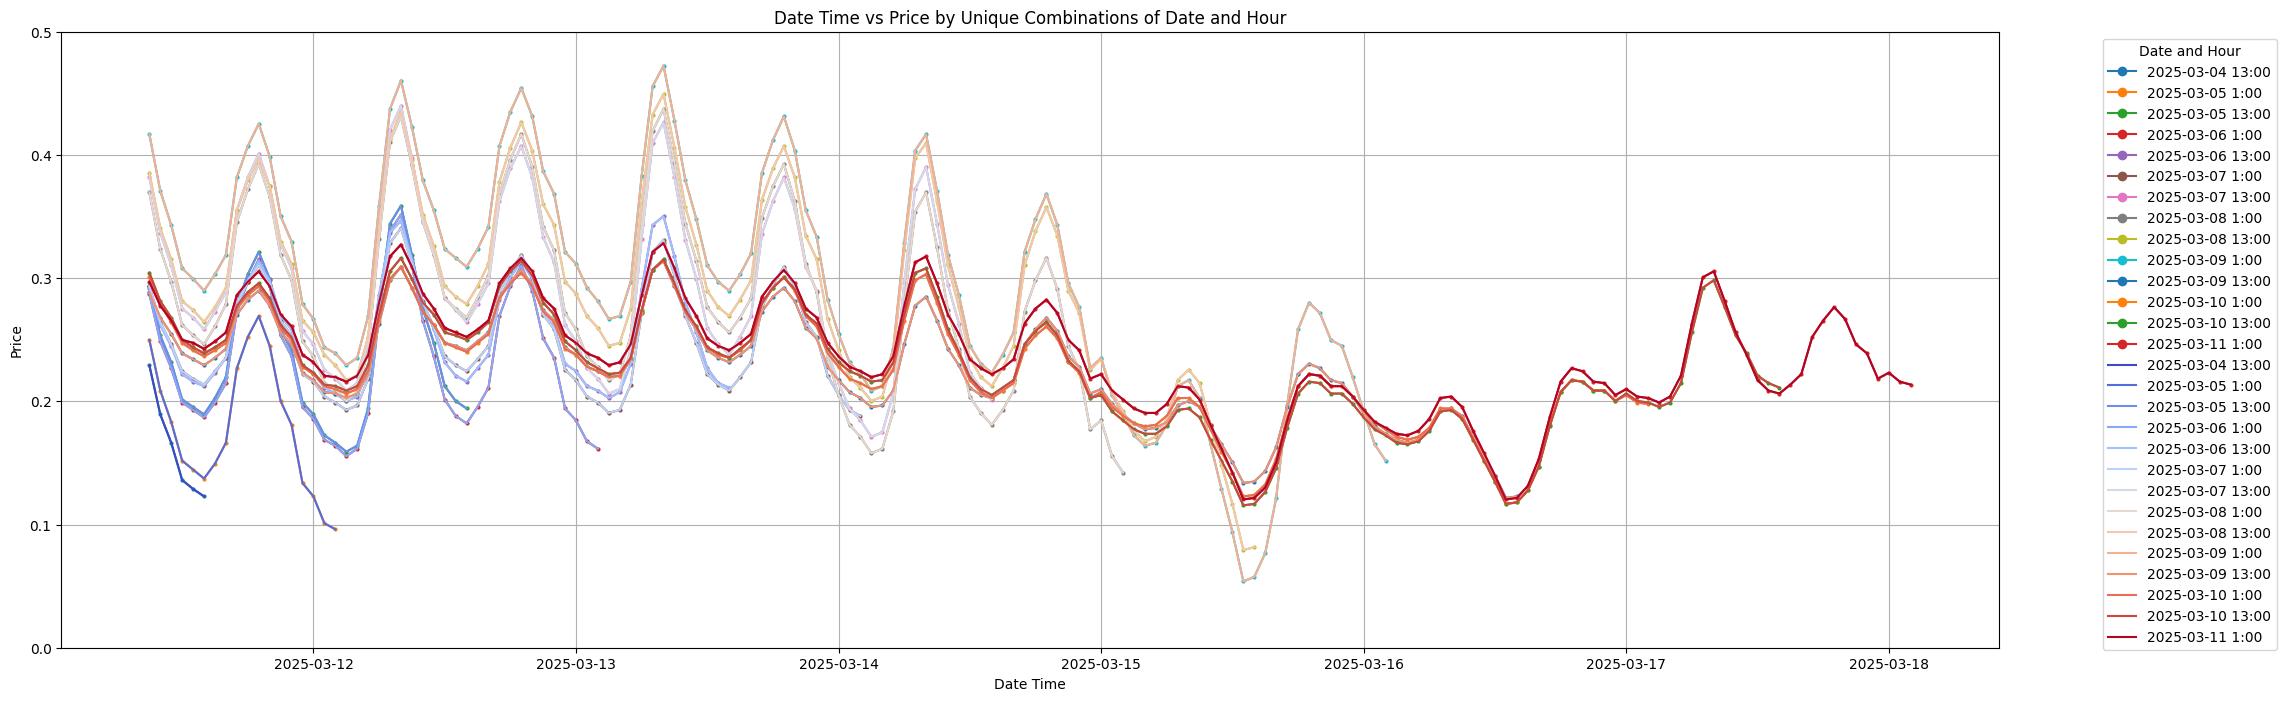

In [29]:
#  how estimate evolve for a particular time period
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 13 or 1
filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 13) | (filtered_df['hour_timestamp'] == 1)]

# Plot the filtered data by each unique combination of date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])

plt.figure(figsize=(25, 8))  # Adjust the width to be 5 times wider

for (date_timestamp, hour_timestamp), group in unique_combinations:
    plt.plot(group['date_time'], group['Price'], marker='o', label=f'{date_timestamp} {hour_timestamp}:00')

import matplotlib.cm as cm
# Generate a color map from red to blue
colors = cm.get_cmap('coolwarm', len(unique_combinations))

for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    plt.plot(group['date_time'], group['Price'], color=colors(i), label=f'{date_timestamp} {hour_timestamp}:00')

plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by Unique Combinations of Date and Hour')
plt.ylim(0.0, 0.5)  # Set y-axis limits
plt.legend(title='Date and Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Change the format to dots being 3x smaller
for line in plt.gca().get_lines():
    line.set_markersize(line.get_markersize() / 3)

plt.show()
